In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
%cd /content/gdrive/MyDrive/SLIIT/Research Project/

/content/gdrive/MyDrive/SLIIT/Research Project


In [6]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('Money printing data.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)




Shape of data (325, 2)


We have to convert the 'Net Credit granted to the Government (NCG)' column's datatype into float.

In [7]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('Money printing data.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)

# define a function to remove comma and convert to float
def remove_comma_and_convert_to_float(s):
    s = s.replace(',', '')
    f = float(s)
    return f


#apply the function to the entire column 
df['Net Credit granted to the Government (NCG)'] = df['Net Credit granted to the Government (NCG)'].apply(remove_comma_and_convert_to_float)

#drop duplicates
dup_sum=df.duplicated(subset='Month').sum()
print(dup_sum)

Shape of data (325, 2)
0


No duplicates available.

Date structure is different in some records in 'Month' column, so we have to reformat them & then we have to convert the string datatype to datetime of the 'Month' column.

Using the following code I am trying to extract the dates that are in a different format (mm-yy) compared to the majority of others. 

In [8]:
import re

# Replace the additional parts with an empty string since Month records contain additional simbols & letters.
df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')

# Trim any leading/trailing whitespace characters
df['Month'] = df['Month'].str.strip()

date_pattern = r'\b\w{3}-\d{2}\b'
mm_yy_dates = [date for date in df['Month'] if re.match(date_pattern, date)] #Take all the elements that are in the format of mm-yy.

<ipython-input-8-9cfdb479612c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')


Now lets try to convert the mm-yy dates into yy-mm preprocess the dataset.

In [9]:
import datetime

# Define the function to convert month-year dates into year-month
def convert_month_date(date_str):
  month = date_str[:3]  # Extract the first two characters as month
  year = date_str[-2:]  # Extract the last two characters as year
  date_str = year + '-' + month  # Reformat the date string as yy-mm
  print(date_str)
  return date_str

# calling the function
converted_dates = [convert_month_date(date) for date in mm_yy_dates]

# Iterate over mm_yy_dates and replace the values in the DataFrame with the values in converted_dates where we have the dates with corrected format. (yy-mm)
for mm_yy_date in mm_yy_dates:
    mm_yy_month, mm_yy_year = mm_yy_date.split('-')  # Split the mm-yy date into month and year
    print("month : " + mm_yy_month + "year : " + mm_yy_year )
    converted_date = next((date for date in converted_dates if date[-3:] == mm_yy_month and date[:2] == mm_yy_year), None)
    print("converted date : " + converted_date)
    if converted_date:
      df.loc[df['Month'] == mm_yy_date, 'Month'] = converted_date

95-Dec
96-Jan
96-Feb
96-Mar
96-Apr
96-May
96-Jun
96-Jul
96-Aug
96-Sep
96-Oct
96-Nov
96-Dec
97-Jan
97-Feb
97-Mar
97-Apr
97-May
97-Jun
97-Jul
97-Aug
97-Sep
97-Oct
97-Nov
97-Dec
98-Jan
98-Feb
98-Mar
98-Apr
98-May
98-Jun
98-Jul
98-Aug
98-Sep
98-Oct
98-Nov
98-Dec
99-Jan
99-Feb
99-Mar
99-Apr
99-May
99-Jun
99-Jul
99-Aug
99-Sep
99-Oct
99-Nov
99-Dec
00-Jan
00-Feb
00-Mar
00-Apr
00-May
00-Jun
00-Jul
00-Aug
00-Sep
00-Oct
00-Nov
00-Dec
15-Oct
22-Mar
22-Apr
22-May
22-Oct
month : Decyear : 95
converted date : 95-Dec
month : Janyear : 96
converted date : 96-Jan
month : Febyear : 96
converted date : 96-Feb
month : Maryear : 96
converted date : 96-Mar
month : Apryear : 96
converted date : 96-Apr
month : Mayyear : 96
converted date : 96-May
month : Junyear : 96
converted date : 96-Jun
month : Julyear : 96
converted date : 96-Jul
month : Augyear : 96
converted date : 96-Aug
month : Sepyear : 96
converted date : 96-Sep
month : Octyear : 96
converted date : 96-Oct
month : Novyear : 96
converted date : 96-No

We have to convert the date column's datatype into datetime. 

In [10]:
#Add 0 for years where only one digit exists. 
df['Month'] = df['Month'].str.replace(r'\b(\d{1})\b', r'0\1', regex=True)

#change the datatype into datetime
df['Month'] = pd.to_datetime(df['Month'], format='%y-%b')

Now the dataset is preprocessed.

Now we have to test whether the data set is stationary or not. Use Augmented Dick-fuller (ADF) for that.

    null hypotheis : the series is non-stationary
    alternative hypothesis : the series is stationary


In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Net Credit granted to the Government (NCG)'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.317868
p-value: 1.000000


As the p-value is greater than 0.05, the null hypothesis cannot be rejected at a significant level of 95%. So the tme series is not stationary. So lets differentitate it.

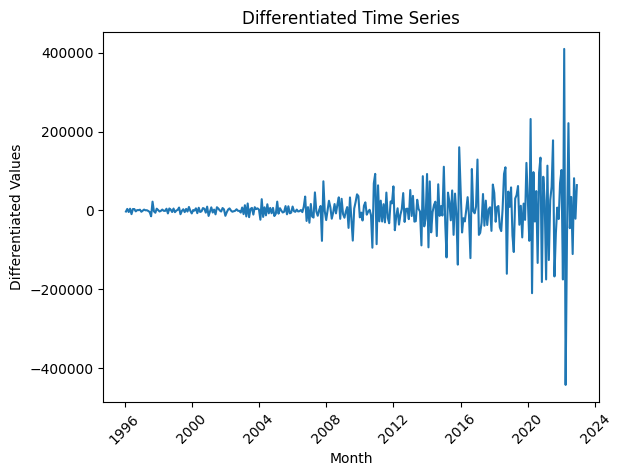

In [12]:
import matplotlib.pyplot as plt

df['diff'] = df['Net Credit granted to the Government (NCG)'].diff().diff()

# drop the first row (since it will have NaN value after differencing)
df.dropna(inplace=True)

# Plot the differentiated values
plt.plot(df['Month'], df['diff'])
plt.xlabel('Month')
plt.ylabel('Differentiated Values')
plt.title('Differentiated Time Series')
plt.xticks(rotation=45)
plt.show()

Lets check the stationarity again.

In [13]:
result = adfuller(df['diff'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.900694
p-value: 0.000000


Lets check the seasonality.

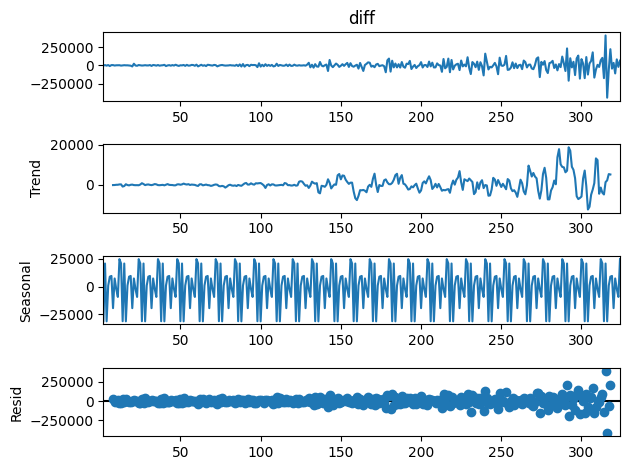

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(df['diff'], model='additive', period=12)

# Plot the seasonal decomposition
fig = decomposition.plot()

As the p-value is less than 0.05, the null hypothesis can be rejected at a significant level of 95%. So the time series is stationary.

So lets try to fit the model. Here after the differentiation, the trend is not exponentially growing, hence trend='additive' & above plots showcase that seasonality = 'additive'.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


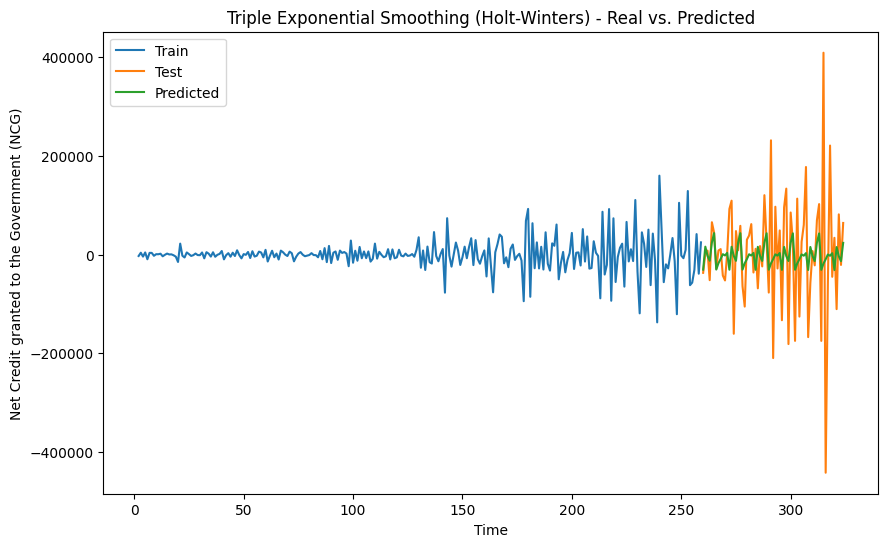

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

df = df['diff']

# train-test split for time series
train_size = int(len(df) * 0.80)
train, test = df[:train_size], df[train_size:]

# create and fit the model
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# make predictions
pred_diff = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Reverse the differentiated values
#pred_cumsum = pred_diff.cumsum()
#pred_actual = train.iloc[-1] + pred_cumsum

# Plotting the real and predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, pred_diff, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Net Credit granted to the Government (NCG)')
plt.title('Triple Exponential Smoothing (Holt-Winters) - Real vs. Predicted')
plt.legend()
plt.show()


Lets check the accuracy of the model.

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test.mean()
rmse=sqrt(mean_squared_error(pred_diff,test))
print(rmse)

115996.1968769648
